# Solution using Embeddings for the Recruit Restaurant Visitor Forecasting kaggle challenge

## Load data

In [1]:
import pandas as pd
import numpy as np
import datetime
table_names = ['air_reserve', 'air_store_info', 'air_visit_data', 'date_info', 
               'hpg_reserve', 'hpg_store_info', 'sample_submission','store_id_relation']
tables = [pd.read_csv('input/'+fname+'.csv', low_memory=False) for fname in table_names]
from IPython.display import HTML
for t in tables: display(t.head())

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [2]:
import math, keras, datetime, keras.backend as K
import matplotlib.pyplot as plt, operator, random, pickle
from pandas_summary import DataFrameSummary
for t in tables: display(DataFrameSummary(t).summary())

Using TensorFlow backend.


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
count,NaN,NaN,NaN,92378
mean,NaN,NaN,NaN,4.48175
std,NaN,NaN,NaN,4.91967
min,NaN,NaN,NaN,1
25%,NaN,NaN,NaN,2
50%,NaN,NaN,NaN,3
75%,NaN,NaN,NaN,5
max,NaN,NaN,NaN,100
counts,92378,92378,92378,92378
uniques,314,4975,7513,71


,air_store_id,air_genre_name,air_area_name,latitude,longitude
count,NaN,NaN,NaN,829,829
mean,NaN,NaN,NaN,35.647,137.415
std,NaN,NaN,NaN,2.08466,3.65097
min,NaN,NaN,NaN,33.212,130.196
25%,NaN,NaN,NaN,34.6951,135.342
50%,NaN,NaN,NaN,35.6581,139.685
75%,NaN,NaN,NaN,35.694,139.752
max,NaN,NaN,NaN,44.0206,144.273
counts,829,829,829,829,829
uniques,829,14,103,108,108


,air_store_id,visit_date,visitors
count,NaN,NaN,252108
mean,NaN,NaN,20.9738
std,NaN,NaN,16.757
min,NaN,NaN,1
25%,NaN,NaN,9
50%,NaN,NaN,17
75%,NaN,NaN,29
max,NaN,NaN,877
counts,252108,252108,252108
uniques,829,478,204


,calendar_date,day_of_week,holiday_flg
count,NaN,NaN,517
mean,NaN,NaN,0.0676983
std,NaN,NaN,0.251471
min,NaN,NaN,0
25%,NaN,NaN,0
50%,NaN,NaN,0
75%,NaN,NaN,0
max,NaN,NaN,1
counts,517,517,517
uniques,517,7,2


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
count,NaN,NaN,NaN,2.00032e+06
mean,NaN,NaN,NaN,5.07378
std,NaN,NaN,NaN,5.41617
min,NaN,NaN,NaN,1
25%,NaN,NaN,NaN,2
50%,NaN,NaN,NaN,3
75%,NaN,NaN,NaN,6
max,NaN,NaN,NaN,100
counts,2000320,2000320,2000320,2000320
uniques,13325,9847,11450,99


,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
count,NaN,NaN,NaN,4690,4690
mean,NaN,NaN,NaN,35.8103,137.676
std,NaN,NaN,NaN,2.13875,3.19723
min,NaN,NaN,NaN,33.3116,130.339
25%,NaN,NaN,NaN,34.6921,135.499
50%,NaN,NaN,NaN,35.6592,139.496
75%,NaN,NaN,NaN,35.7034,139.738
max,NaN,NaN,NaN,43.7748,143.715
counts,4690,4690,4690,4690,4690
uniques,4690,34,119,129,129


,id,visitors
count,NaN,32019
mean,NaN,0
std,NaN,0
min,NaN,0
25%,NaN,0
50%,NaN,0
75%,NaN,0
max,NaN,0
counts,32019,32019
uniques,32019,1


,air_store_id,hpg_store_id
count,150,150
unique,150,150
top,air_375a5241615b5e22,hpg_945c2807cef88022
freq,1,1
counts,150,150
uniques,150,150
missing,0,0
missing_perc,0%,0%
types,unique,unique


## Quick facts about the data
1) No missing values (going by missing statistic in the above summaries)

2) Air has 92,378 reservations in the given period with a mean, median, sd and max of 4.5, 3, 4.9 and 100 visitors. There are 71 unique group sizes (reserve_visitors)

3) Air has 829 unique restaurants belonging to 14 genres in 103 unique areas (air_area_name).

4) A total of 252108 visitors have eaten at the restaurants (Air U hpg U Others) during the given period with a mean, median, sd and max of 21, 17, 16.8 and 877 visitors. There are 204 unique group sizes (visitors)

5) About 7% holidays during the period of 517 days.

6) hpg has 2,000,320 reservations with a mean, median, sd and max of 5.1, 3, 5.4 and 100. There are 99 unique group sizes (reserve_visitors). The max of 100 across both the air and hpg systems is likely due to either a limitation of the software / a result of some regulation. 

7) hpg has 4690 unique restaurants belonging to 34 genres in 119 unique areas.

8) 150 restaurants are registered in both the booking systems



First let's derive a date column from the datetime field from both the reservation data. First convert all date fields to dates:

In [3]:
air_reserve, air_store_info, \
air_visit_data, date_info, hpg_reserve, \
hpg_store_info, sample_submission,store_id_relation = tables
air_reserve.visit_datetime = air_reserve.visit_datetime.apply(pd.to_datetime)
air_reserve.reserve_datetime = air_reserve.reserve_datetime.apply(pd.to_datetime)
hpg_reserve.visit_datetime = hpg_reserve.visit_datetime.apply(pd.to_datetime)
hpg_reserve.reserve_datetime = hpg_reserve.reserve_datetime.apply(pd.to_datetime)
air_visit_data.visit_date = air_visit_data.visit_date.apply(pd.to_datetime)
date_info.calendar_date = date_info.calendar_date.apply(pd.to_datetime)

In [4]:
air_reserve['visit_date']= air_reserve.visit_datetime.dt.date
air_reserve['reserve_date']= air_reserve.reserve_datetime.dt.date
hpg_reserve['visit_date']= hpg_reserve.visit_datetime.dt.date
hpg_reserve['reserve_date']= hpg_reserve.reserve_datetime.dt.date
air_visit_data['visit_date'] = air_visit_data.visit_date.dt.date
date_info['calendar_date'] = date_info.calendar_date.dt.date

Extract air id and date from the submission file to check which restaurants are relevant for prediction. 

In [5]:
sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.date = sample_submission.date.apply(pd.to_datetime)
sample_submission.date = sample_submission.date.dt.date


Define some helper functions

In [6]:
def join_df(left, right, left_on, right_on=None,inner_join=False):
    if right_on is None: right_on = left_on
    if inner_join: return left.merge(right,left_on=left_on,right_on=right_on,suffixes=("","_y"))
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

def add_datepart(df,column_name):
    df["Year"] = df[column_name].dt.year
    df["Month"] = df[column_name].dt.month
    df["Week"] = df[column_name].dt.week
    df["Day"] = df[column_name].dt.day
    


In [7]:
air_ids_in_submission = sample_submission.air_store_id.unique()
hpg_ids_in_submission = join_df(store_id_relation,sample_submission,"air_store_id",inner_join=True)['hpg_store_id'].unique()
print(len(hpg_ids_in_submission))

150


So, all the restaurants in both the booking systems are present in the submission file. Great! So, the challenge is likely that of predicting the given restaurants' reservations given the other restaurants' reservations. Keep Bayesian in mind. Refer facebook checkin prediction challenge winner write-up. 

Get restaurant distance matrices to add the following features:

1) Number of restaurants within a certain radii (choose the radii from the distribution of distances)

2) Number of restaurants of the same class within a certain radii (choose radii based on the distribution of distances)

In [8]:
hpg_locations = hpg_store_info[["hpg_store_id","latitude","longitude"]]
print(len(set(hpg_locations.hpg_store_id) & set(store_id_relation.hpg_store_id)))
print(len(set(store_id_relation.hpg_store_id) - set(hpg_locations.hpg_store_id)))
print(len(set(store_id_relation.air_store_id) - set(air_store_info.air_store_id)))
#discard restaurants in both booking systems
hpg_locations = hpg_locations[~(hpg_locations.hpg_store_id.isin(store_id_relation.hpg_store_id))]
hpg_locations.rename(columns={'hpg_store_id':'air_store_id'},inplace=True)


63
87
0


87 hpg stores in 'store_id_relation' are not in 'hpg_store_info' data. But all air stores are present across the two data frames.

In [9]:
from scipy.spatial import *
air_locations = air_store_info[["air_store_id","latitude","longitude"]]

air_locations = pd.concat([air_locations,hpg_locations],axis=0,ignore_index=True)
air_locations.set_index("air_store_id",inplace=True)
distances = pd.DataFrame(distance_matrix(air_locations.values, air_locations.values), index=air_locations.index, columns=air_locations.index)

In [10]:
distance_values = distances.as_matrix()
print(distance_values.shape)
%matplotlib inline
distance_values = (distance_values.ravel())
#distance_values = distance_values[distance_values>0]
from scipy import stats
print(stats.describe(distance_values))
print("Quartiles")
print(np.percentile(distance_values,[25,50,75,90]))
print("Centiles")
print(np.percentile(distance_values,range(10,100,10)))


(5456, 5456)
DescribeResult(nobs=29767936, minmax=(0.0, 17.540426494759156), mean=4.1696664832657486, variance=12.818557745220481, skewness=0.567136361965606, kurtosis=-0.47945288314308643)
Quartiles
[ 0.32769325  4.2994748   7.35259232  9.52828183]
Centiles
[ 0.06462589  0.16455199  1.06341965  2.78602698  4.2994748   4.52120788
  5.26671818  7.54669243  9.52828183]


(array([  6.07299000e+06,   1.69749200e+06,   7.16252000e+05,
          1.67834000e+05,   1.46794000e+05,   1.19752000e+05,
          1.48184000e+05,   7.26660000e+04,   3.79744000e+05,
          1.22666000e+05,   1.90636000e+05,   1.74510000e+05,
          9.44866000e+05,   6.30660000e+05,   7.18900000e+04,
          3.70768000e+05,   6.54932000e+05,   4.98552000e+05,
          8.52060000e+04,   7.37000000e+04,   3.27180000e+04,
          4.49680000e+04,   3.07232000e+05,   5.39078000e+05,
          2.63468400e+06,   1.03035000e+06,   1.07824200e+06,
          5.99712000e+05,   4.02804000e+05,   8.19494000e+05,
          1.83816000e+05,   1.26880000e+04,   8.13180000e+04,
          2.66880000e+04,   3.85740000e+04,   1.32274000e+05,
          3.17904000e+05,   1.44644000e+05,   8.67060000e+04,
          4.69960000e+04,   2.21756000e+05,   4.39524000e+05,
          1.17721000e+06,   8.30180000e+05,   7.61380000e+04,
          2.71700000e+04,   7.95240000e+04,   6.09420000e+04,
        

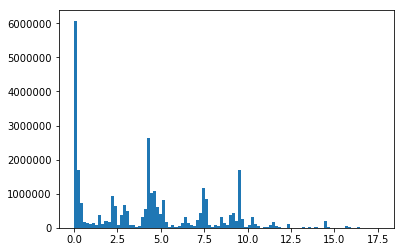

In [11]:
plt.hist(distance_values,bins=100)


(array([ 4736874.,  1483418.,   742942.,  1236744.,   273866.,   117064.,
           63644.,    54024.,    98240.,    48862.]),
 array([ 0.        ,  0.09999878,  0.19999756,  0.29999634,  0.39999511,
         0.49999389,  0.59999267,  0.69999145,  0.79999023,  0.89998901,
         0.99998778]),
 <a list of 10 Patch objects>)

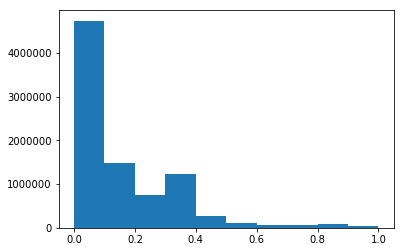

In [12]:
plt.hist(distance_values[distance_values<1])

(array([ 427064.,    1380.,   10020.,   21772.,    5412.,   20438.,
           9772.,   37238.,    9810.,   30180.]),
 array([ 0.        ,  0.00099941,  0.00199882,  0.00299823,  0.00399763,
         0.00499704,  0.00599645,  0.00699586,  0.00799527,  0.00899468,
         0.00999409]),
 <a list of 10 Patch objects>)

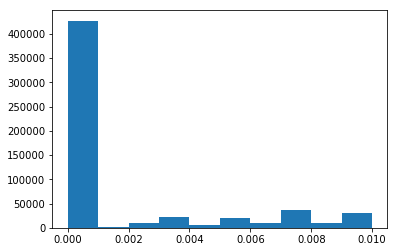

In [13]:
plt.hist(distance_values[distance_values<0.01])


In [14]:
print(len((distance_values[distance_values==0])))

427064


Let's look at the distribution of distance to the nearest restaurants both within and across genres

In [15]:
distances.reset_index(inplace=True)
air_types = (air_store_info.air_genre_name)
hpg_types = (hpg_store_info.hpg_genre_name)
store_relation_merged = join_df(store_id_relation,air_store_info,'air_store_id',inner_join=True)
store_relation_merged = join_df(store_relation_merged,hpg_store_info,'hpg_store_id',inner_join=True)
genre_dict = pd.Series(store_relation_merged.hpg_genre_name.values,index=store_relation_merged.air_genre_name).to_dict()
print(genre_dict)

{'Dining bar': 'Spain Bar/Italian Bar', 'Izakaya': 'Japanese style', 'Japanese food': 'Japanese style', 'Western food': 'Steak/Hamburger/Curry', 'Italian/French': 'Spain Bar/Italian Bar', 'Yakiniku/Korean food': 'Grilled meat', 'Bar/Cocktail': 'Cafe', 'Okonomiyaki/Monja/Teppanyaki': 'Okonomiyaki/Monja/Teppanyaki', 'Karaoke/Party': 'Party'}


Let's look at the air_genre_name not in store_id_relation to come up with mappings between air_genre_name and hpg_genre_name

In [16]:
print(store_id_relation.shape)
print(store_relation_merged.shape)
print(set(air_store_info.air_genre_name) - set(store_relation_merged.air_genre_name))
#print(set(hpg_store_info.hpg_genre_name) - set(store_relation_merged.air_genre_name))
print("Cafe / Sweets")
print(hpg_store_info[hpg_store_info.hpg_genre_name.str.contains('Cafe')].hpg_genre_name.unique())
print(hpg_store_info[hpg_store_info.hpg_genre_name.str.contains('Sweets')].hpg_genre_name.unique())
print("Other")
print(hpg_store_info[hpg_store_info.hpg_genre_name.str.contains('other')].hpg_genre_name.unique())
print("International cuisine")
print(hpg_store_info[hpg_store_info.hpg_genre_name.str.contains('International')].hpg_genre_name.unique())
print("Asian")
print(hpg_store_info[hpg_store_info.hpg_genre_name.str.contains('asian')].hpg_genre_name.unique())
print("Creative cuisine")
print(hpg_store_info[hpg_store_info.hpg_genre_name.str.contains('Creative')].hpg_genre_name.unique())

(150, 2)
(63, 10)
{'International cuisine', 'Asian', 'Other', 'Cafe/Sweets', 'Creative cuisine'}
Cafe / Sweets
['Cafe']
['Sweets']
Other
[]
International cuisine
['International cuisine']
Asian
[]
Creative cuisine
['Creative Japanese food']


In [17]:
genre_dict['Cafe/Sweets']=['Cafe','Sweets']
genre_dict['International cuisine'] = 'International cuisine'
genre_dict['Creative Japanese food'] = 'Creative Japanese food'
#print(genre_dict)
#print(genre_dict['other'])

In [44]:

#Each degree latitude/longitude is about 70 miles. So restrict radii to less than 20 miles / ~0.3 degree lat / long
all_rest_by_dist={'Dist_1':0}
grp_rest_by_dist={'Dist_1':0,'Dist_2':0.01, 'Dist_3':0.1, 'Dist_4':0.3}
def get_n_restaurants(restaurant_id,distance,grp=None):
    #print("restaurants....")
    #print(restaurant_id)
    #print(len(restaurant_id))
    #dt = (distances.loc[distances.air_store_id==restaurant_id].values).ravel()[1:]
    dt = distances.loc[distances.air_store_id==restaurant_id]
    #print(dt)
    if grp is not None:
        #print("getting restaurants in group")
        # filter restaurants belonging to the comparable group
        #dt = distances.loc[distances.air_store_id.isin(restaurant_id)]
        dt = dt.loc[:,dt.columns.isin(grp)]
        dt = dt.loc[:,dt.columns!='air_store_id'].values.ravel()
    else:
        dt = dt.values.ravel()[1:]
    #dt = dt[1:]
    #print("all restaurants "+str(len(dt)))
    #if 'air' in restaurant_id and grp is not None:
    #    print(air_store_info[air_store_info.air_store_id.isin(grp)])
    #elif 'hpg' in restaurant_id and grp is not None:
    #    print(hpg_store_info[hpg_store_info.hpg_store_id.isin(grp)])
    #dt = dt[0][1:]
    return (len(dt[dt<=distance])-1) #discount the current restaurant_id
def get_restaurants_in_group(air_grp):
    # if no mapping found for air_genre_name return just the air_genre_name restaurant ids
    try:
        hpg_grp = genre_dict[air_grp]
    except KeyError:
        return air_store_info.loc[air_store_info.air_genre_name==air_grp]["air_store_id"].values
    #print(air_grp+"++++"+hpg_grp)
    if type(hpg_grp) == str:
        rest_in_grp = np.concatenate((air_store_info.loc[air_store_info.air_genre_name==air_grp]["air_store_id"].values,\
                     hpg_store_info.loc[hpg_store_info.hpg_genre_name==hpg_grp]["hpg_store_id"].values))
    else:
        rest_in_grp = np.concatenate((air_store_info.loc[air_store_info.air_genre_name==air_grp]["air_store_id"].values,\
                     hpg_store_info.loc[hpg_store_info.hpg_genre_name.isin(hpg_grp)]["hpg_store_id"].values))
    return rest_in_grp
def get_neighbor_restaurants(restaurant_id,distance,grp=False):
    dt = distances.loc[distances.air_store_id==restaurant_id]
    dt = dt.T.reset_index().iloc[2:].reset_index()
    dt.rename(columns={dt.columns[2]:'distance'},inplace=True)
    if grp:
        grp = air_store_info.loc[air_store_info.air_store_id==restaurant_id]
        if len(grp)==0:
            grp = hpg_store_info.loc[hpg_store_info.hpg_store_id==restaurant_id]
        grp.rename(columns={'air_genre_name':'genre_name','hpg_genre_name':'genre_name'},inplace=True)
        grp = grp.genre_name.values[0]
        rest_in_grp = get_restaurants_in_group(grp)
        dt = dt.loc[dt.air_store_id.isin(rest_in_grp)]
    return dt.loc[dt.distance<=distance].air_store_id.values
#print(get_neighbor_restaurants('air_0f0cdeee6c9bf3d7',0,True))
#print(get_restaurants_within_distance('air_0f0cdeee6c9bf3d7',0,True))

def get_n_restaurants_within_distance(restaurant_id,distance,air_grp=None):
    if air_grp==None : 
        #dt = (distances[distances.air_store_id==restaurant_id].values)
        #dt = dt[0][1:]
        return get_n_restaurants(restaurant_id,distance)
    grp = air_store_info.loc[air_store_info.air_store_id==restaurant_id]
    if len(grp)==0:
        grp = hpg_store_info.loc[hpg_store_info.hpg_store_id==restaurant_id]
    grp.rename(columns={'air_genre_name':'genre_name','hpg_genre_name':'genre_name'},inplace=True)
    grp = grp.genre_name.values[0]
    return get_n_restaurants(restaurant_id,distance,get_restaurants_in_group(grp))
    #return len(get_neighbor_restaurants(restaurant_id,distance,air_grp)-1)

def get_nneighbors(row,distance,grp=None):
    return get_n_restaurants_within_distance(row['air_store_id'],distance,grp)

#print(get_restaurants_within_distance('air_a38f25e3399d1b25',0))
#print(get_restaurants_within_distance('air_a38f25e3399d1b25',0,True))
#print(air_store_info.loc[[549]])
#print(get_nneighbors(air_store_info.iloc[[96]],0)) 
#air_store_info = air_store_info.drop('n_neighbors_all',axis=1)
#air_store_info.columns
#print(store_relation_merged.head())
#print(air_store_info.iloc[[96]])
#print(air_store_info.loc[air_store_info.air_store_id=='air_a38f25e3399d1b25'])
#print(air_store_info.loc[[549]])

In [45]:
air_store_info['n_neighbors_group_0'] = air_store_info.apply(lambda row : get_nneighbors(row,0,True),axis=1)
air_store_info['n_neighbors_0'] = air_store_info.apply(lambda row : get_nneighbors(row,0),axis=1)
#air_store_info.loc[air_store_info.air_genre_name=='Cafe/Sweets']
#air_store_info['n_neighbors_all'] = air_store_info.apply(lambda row : get_nneighbors(row,0),axis=1)

/home/suresh/anaconda3/envs/aind-nlp/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [ ]:
print(stats.describe(air_store_info.n_neighbors_0))
print("Quartiles")
print(np.percentile(air_store_info.n_neighbors_0,[25,50,75,90]))
print("Centiles")
print(np.percentile(air_store_info.n_neighbors_0,range(10,100,10)))
print(stats.describe(air_store_info.n_neighbors_group_0))
print("Quartiles")
print(np.percentile(air_store_info.n_neighbors_group_0,[25,50,75,90]))
print("Centiles")
print(np.percentile(air_store_info.n_neighbors_group_0,range(10,100,10)))
#plt.hist(air_store_info['n_neighbors_all'])

In [ ]:
plt.hist(air_store_info.n_neighbors_0)
plt.title("Number of restaurants (across group)in the neighborbood")


In [ ]:
plt.hist(air_store_info.n_neighbors_group_0)
plt.title("Number of restaurants in group in the neighborbood")

The training data will be 'air_visit_data'. We can summarize 'air_reserve', by adding total reservations within and across groups by distances. Ditto with hpg_reserve. Let's merge air_visit, air_store_info and air_reserve to get all the required stats

In [69]:
air_reserve_summary = air_reserve[['air_store_id','visit_date','reserve_visitors']].groupby(['air_store_id','visit_date'],as_index=False).agg({'reserve_visitors':sum}).reset_index()
air_reserve_summary.rename(columns={'reserve_visitors':'n_reserve_visitors'},inplace=True)
air_reserve_summary2 = air_reserve[['air_store_id','visit_date']].groupby(['air_store_id','visit_date']).size().reset_index()
air_reserve_summary2.rename(columns={0:'n_reservations'},inplace=True)
air_reserve_summary = join_df(air_reserve_summary,air_reserve_summary2,['air_store_id','visit_date'])
air_reserve_summary.drop('index',axis=1,inplace=True)
print(air_reserve_summary.shape)
air_reserve_summary = join_df(air_reserve_summary,air_store_info,'air_store_id')
print(air_reserve_summary.shape)
air_reserve_summary.head()
#air_all = join_df(air_visit_data,air_store_info,"air_store_id")
#air_all = join_df(air_all,air_reserve_summary,["air_store_id","visit_date"])
#air_all.reserve_visitors.fillna(0,inplace=True)
#air_all.n_reservations.fillna(0,inplace=True)
#print(air_all.shape)
#print(air_all.head())


(29830, 4)
(29830, 10)


,air_store_id,visit_date,n_reserve_visitors,n_reservations,air_genre_name,air_area_name,latitude,longitude,n_neighbors_group_0,n_neighbors_0
0,air_00a91d42b08b08d9,2016-10-31,2,1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,3,19
1,air_00a91d42b08b08d9,2016-12-05,9,1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,3,19
2,air_00a91d42b08b08d9,2016-12-14,18,1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,3,19
3,air_00a91d42b08b08d9,2016-12-17,2,1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,3,19
4,air_00a91d42b08b08d9,2016-12-20,4,1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,3,19


In [74]:
hpg_reserve_summary = hpg_reserve[['hpg_store_id','visit_date','reserve_visitors']].groupby(['hpg_store_id','visit_date'],as_index=False).agg({'reserve_visitors':sum}).reset_index()
hpg_reserve_summary.rename(columns={'reserve_visitors':'n_reserve_visitors'},inplace=True)
hpg_reserve_summary2 = hpg_reserve[['hpg_store_id','visit_date']].groupby(['hpg_store_id','visit_date']).size().reset_index()
hpg_reserve_summary2.rename(columns={0:'n_reservations'},inplace=True)
hpg_reserve_summary = join_df(hpg_reserve_summary,hpg_reserve_summary2,['hpg_store_id','visit_date'])
hpg_reserve_summary.drop('index',axis=1,inplace=True)
hpg_reserve_summary.n_reserve_visitors.fillna(0,inplace=True)
hpg_reserve_summary.n_reservations.fillna(0,inplace=True)
print(hpg_reserve_summary.shape)
hpg_reserve_summary.head()

(1355053, 4)


,hpg_store_id,visit_date,n_reserve_visitors,n_reservations
0,hpg_001112ef76b9802c,2016-02-26,9,1
1,hpg_001112ef76b9802c,2016-03-17,3,1
2,hpg_001112ef76b9802c,2016-03-31,5,1
3,hpg_001112ef76b9802c,2016-04-05,13,1
4,hpg_001112ef76b9802c,2016-04-18,9,1


Now, add the total visitors from reservations / total reservations and total visitors within specified distances across and within groups and for each restaurant

In [57]:
def get_total_reservations_for_id(restaurant_id,visit_date,distance,grp=False):
    neighbor_restaurants = get_neighbor_restaurants(restaurant_id,distance,grp)
    return np.sum(air_reserve_summary.loc[(air_reserve_summary.visit_date==visit_date) & (air_reserve_summary.air_store_id.isin(neighbor_restaurants))].n_reserve_visitors)
def get_total_reservations(r,distance,grp):
    return get_total_reservations_for_id(r['air_store_id'],r['visit_date'],distance,grp)
def get_total_visitors_for_id(restaurant_id,visit_date,distance,grp=False):
    neighbor_restaurants = get_neighbor_restaurants(restaurant_id,distance,grp)
    return np.sum(air_visit_data.loc[(air_visit_data.visit_date==visit_date) & (air_visit_data.air_store_id.isin(neighbor_restaurants))].visitors)
def get_total_visitors(r,distance,grp):
    return get_total_visitors_for_id(r['air_store_id'],r['visit_date'],distance,grp)
def get_number_reservations_for_id(restaurant_id,visit_date,distance,grp=False):
    neighbor_restaurants = get_neighbor_restaurants(restaurant_id,distance,grp)
    return np.sum(air_reserve_summary.loc[(air_reserve_summary.visit_date==visit_date) & (air_reserve_summary.air_store_id.isin(neighbor_restaurants))].n_reservations)
def get_number_reservations(r,distance,grp):
    return get_number_reservations_for_id(r['air_store_id'],r['visit_date'],distance,grp)
#air_reserve_summary.head().apply(lambda row : get_total_reservations(row,0,False),axis=1)
#air_store_info.head().apply(lambda row : get_nneighbors(row,0,True),axis=1)
#air_reserve_summary['air_store_id']

In [75]:
air_reserve_summary['n_reservations_0'] = air_reserve_summary.apply(lambda row : get_number_reservations(row,0,False),axis=1)
air_reserve_summary['n_reservations_grp_0'] = air_reserve_summary.apply(lambda row : get_number_reservations(row,0,True),axis=1)


/home/suresh/anaconda3/envs/aind-nlp/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [278]:
air_reserve_summary['n_reserve_visitors_0'] = air_reserve_summary.apply(lambda row : get_total_reservations(row,0,False),axis=1)
air_reserve_summary['n_reserve_visitors_grp_0'] = air_reserve_summary.apply(lambda row : get_total_reservations(row,0,True),axis=1)


In [130]:
date_info = pd.read_csv("input/date_info.csv")
date_info.calendar_date = date_info.calendar_date.apply(pd.to_datetime)
date_info.calendar_date = date_info.calendar_date.dt.date
holiday_cols = ["calendar_date", "holiday_flg"]
class elapsed(object):
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        
    def get(self, row):
        if (row[self.fld]): self.last = row.calendar_date
        return (row.calendar_date-self.last).days

def add_elapsed(fld, prefix):
    sh_el = elapsed(fld)
    date_info[prefix+"_"+fld] = date_info.apply(sh_el.get, axis=1)
def is_golden_holiday(date):
    return 1 if ((date.day==29 and date.month==4) or (date.day in [3,4,5] and date.month==5)) else 0
date_info = date_info[holiday_cols]
field = 'holiday_flg'
date_info.sort_values(['calendar_date'],ascending=True,inplace=True)
add_elapsed(field,'after')
#date_info["after_holiday_flg"].fillna(pd.Timedelta(0)).dt.days
date_info.sort_values(['calendar_date'],ascending=False,inplace=True)
add_elapsed(field,'before')
#longest non-holiday stretch is following the golden week. So set nans to the longest streak
date_info.before_holiday_flg.fillna(np.min(date_info.before_holiday_flg),inplace=True)
#date_info.loc[date_info.before_holiday_flg.isnull()] = pd.Timedelta(0).days
date_info['golden_holiday'] =date_info.calendar_date.apply(is_golden_holiday)
#print(date_info)


In [132]:
print(date_info.head())
print(date_info.tail())
print(date_info.after_holiday_flg.unique())
print(date_info.before_holiday_flg.unique())
#air_visit_all = join_df(air_visit_data,air_reserve_summary,['air_store_id','visit_date'])
#air_visit_data.shape #(252108, 15)

    calendar_date  holiday_flg  after_holiday_flg  before_holiday_flg  \
516    2017-05-31            0                 26               -73.0   
515    2017-05-30            0                 25               -73.0   
514    2017-05-29            0                 24               -73.0   
513    2017-05-28            0                 23               -73.0   
512    2017-05-27            0                 22               -73.0   

     golden_holiday  
516               0  
515               0  
514               0  
513               0  
512               0  
  calendar_date  holiday_flg  after_holiday_flg  before_holiday_flg  \
4    2016-01-05            0                  2                -6.0   
3    2016-01-04            0                  1                -7.0   
2    2016-01-03            1                  0                 0.0   
1    2016-01-02            1                  0                 0.0   
0    2016-01-01            1                  0                 0.0   

  

In [ ]:
air_visit_data['n_visitors_0'] = air_visit_data.apply(lambda row : get_total_visitors(row,0,False),axis=1)
air_visit_data['n_visitors_grp_0'] = air_visit_data.apply(lambda row : get_total_visitors(row,0,True),axis=1)
add_datepart(air_visit_all)


In [271]:
import pickle
pickle.dump(air_visit_data,open('input/air_visit_data.pkl','wb')) 
#air_visit_data = air_visit_data+air_reserve_summary
#this data frame has air_visit, air_reserve, individual and grp summary stats including by distance
##about air_reserve_summary
#air_reserve_summary = air_reserve[['air_store_id','visit_date','reserve_visitors']].groupby(['air_store_id','visit_date']).agg({'reserve_visitors':sum}).reset_index()
#air_reserve_summary.rename(columns={'reserve_visitors':'n_reserve_visitors'},inplace=True)
#hpg_reserve_summary = hpg_reserve[['hpg_store_id','visit_date','reserve_visitors']].groupby(['hpg_store_id','visit_date']).agg({'reserve_visitors':sum}).reset_index()
#hpg_reserve_summary.rename(columns={'reserve_visitors':'n_reserve_visitors'},inplace=True)
#air_reserve_summary = join_df(air_reserve_summary,air_store_info,"air_store_id")
#hpg_reserve_summary = join_df(hpg_reserve_summary,hpg_store_info,"hpg_store_id")
#air_reserve_info_merged = join_df(left=air_reserve,right=air_store_info,left_on="air_store_id")
#hpg_reserve_info_merged = join_df(left=hpg_reserve,right=hpg_store_info,left_on="hpg_store_id")
#air_reserve_grp_summary = air_reserve_info_merged[['air_genre_name','visit_date','reserve_visitors']].groupby(['air_genre_name','visit_date']).agg({'reserve_visitors':sum}).reset_index()
#air_reserve_grp_summary.rename(columns={'reserve_visitors':'n_reserve_visitors_grp'},inplace=True)
#hpg_reserve_grp_summary = hpg_reserve_info_merged[['hpg_genre_name','visit_date','reserve_visitors']].groupby(['hpg_genre_name','visit_date']).agg({'reserve_visitors':sum}).reset_index()
#hpg_reserve_grp_summary.rename(columns={'reserve_visitors':'n_reserve_visitors_grp'},inplace=True)


In [274]:
air_visit_data.head()

,air_store_id,visit_date,visitors,n_reserve_visitors,air_genre_name,air_area_name,latitude,longitude,n_neighbors_group_0,n_neighbors_0,n_reserve_visitors_grp,n_reserve_visitors_0,n_reserve_visitors_grp_0,n_visitors_0,n_visitors_grp_0
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313,46
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315,82
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,371,58
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,335,50
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109,12


In [275]:
air_store_info[air_store_info.air_store_id=='air_ba937bf13d40fb24']

,air_store_id,air_genre_name,air_area_name,latitude,longitude,n_neighbors_group_0,n_neighbors_0
112,air_ba937bf13d40fb24,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,50


In [276]:
air_reserve_summary[air_reserve_summary.air_store_id=='air_ba937bf13d40fb24']

,air_store_id,visit_date,n_reserve_visitors,air_genre_name,air_area_name,latitude,longitude,n_neighbors_group_0,n_neighbors_0,n_reserve_visitors_grp,n_reserve_visitors_0,n_reserve_visitors_grp_0
